In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt

Load DATASET

In [4]:
DATA_IMAGE_DIR = './data_partitioned/image'
DATA_MASK_DIR = './data_partitioned/mask'
x_train_dir = os.path.join(DATA_IMAGE_DIR, 'train')
y_train_dir = os.path.join(DATA_MASK_DIR, 'train')

x_valid_dir = os.path.join(DATA_IMAGE_DIR, 'val')
y_valid_dir = os.path.join(DATA_MASK_DIR, 'val')

x_test_dir = os.path.join(DATA_IMAGE_DIR, 'test')
y_test_dir = os.path.join(DATA_MASK_DIR, 'test')

Dataloader and utility functions

In [9]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x
    

# classes for data loading and preprocessing
class Dataset:
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['tree_plantation_boundary']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)
    
    
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

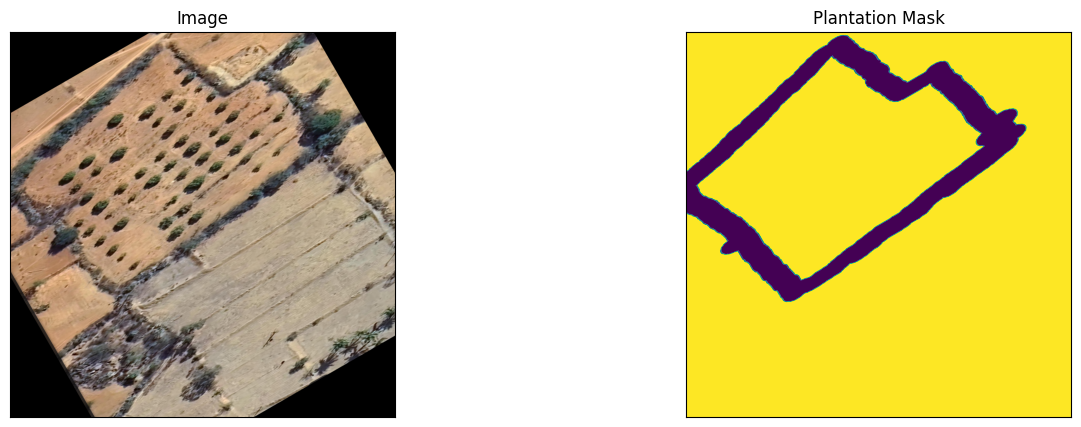

In [11]:
# Lets look at data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=['tree_plantation_boundary'])

image, mask = dataset[5] # get some sample
visualize(
    image=image, 
    plantation_mask=mask[..., 0].squeeze()
)

Segmentation model training

In [14]:
!pip install git+https://github.com/qubvel/segmentation_models

  Cloning https://github.com/qubvel/segmentation_models to c:\users\asus\appdata\local\temp\pip-req-build-f2ashl0j
  Resolved https://github.com/qubvel/segmentation_models to commit e951c6747f75fa9e7240816d1c79dd2e66813123
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


DEPRECATION: Loading egg at c:\python312\lib\site-packages\flow-0.3.5-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\python312\lib\site-packages\looseversion-1.3.0-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/segmentation_models 'C:\Users\ASUS\AppData\Local\Temp\pip-req-build-f2ashl0j'
  Running command git submodule update --init --recursive -q


In [15]:
import segmentation_models as sm

AttributeError: module 'keras.api.utils' has no attribute 'generic_utils'

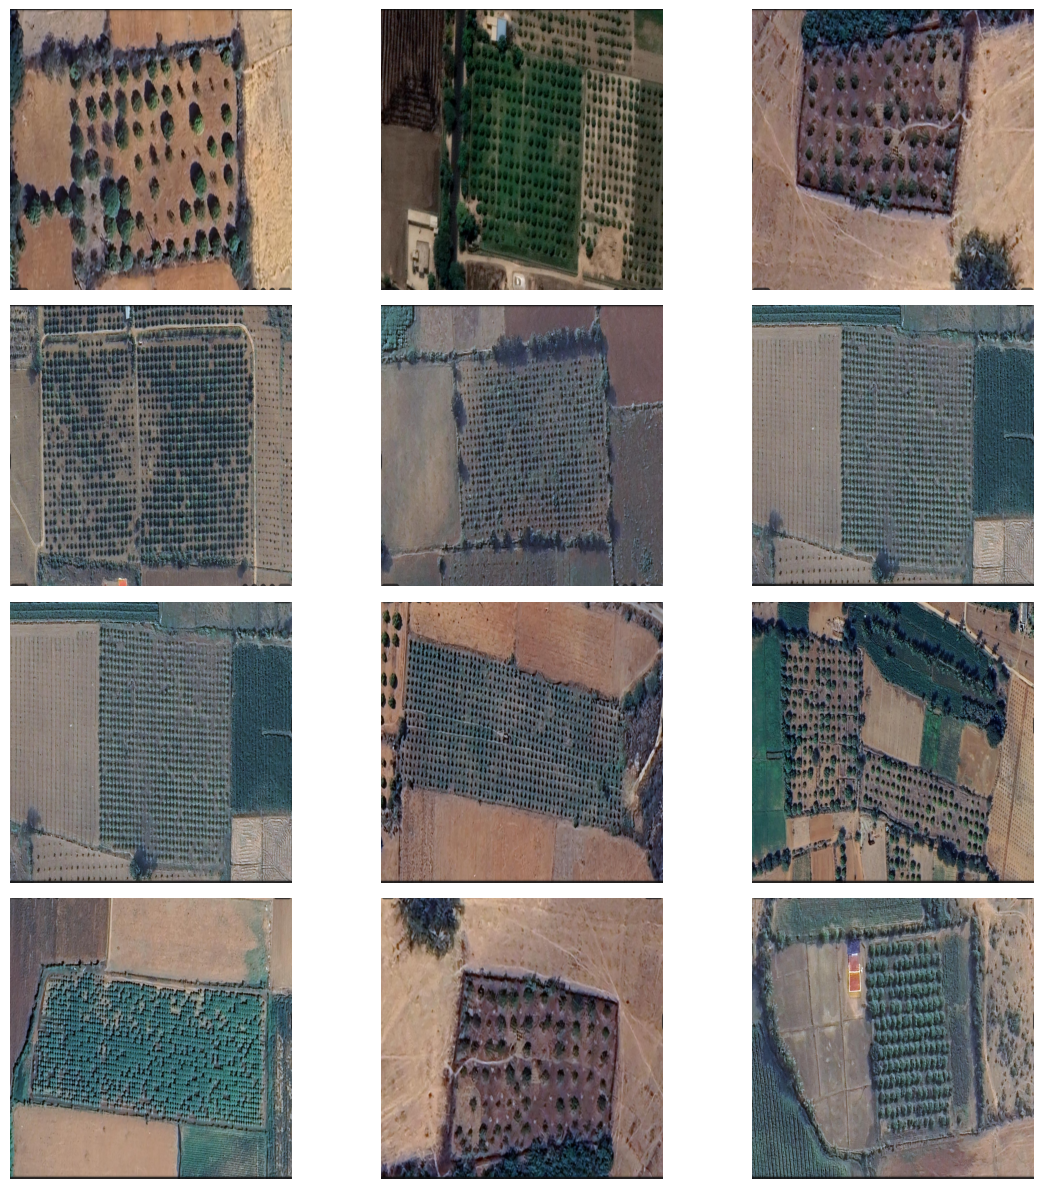

In [6]:
import matplotlib.pyplot as plt
import os
from PIL import Image

# Folder path containing the images
folder_path = './temp'

# List to store images
images = []

# Loop through all files in the folder
for filename in os.listdir(folder_path):
    # Check if the file is an image
    if filename.endswith('.jpg') or filename.endswith('.png'):
        # Read the image using PIL
        image = Image.open(os.path.join(folder_path, filename))
        # Append the image to the list
        images.append(image)

# Create a figure and axis array with 4 rows and 3 columns
fig, axs = plt.subplots(4, 3, figsize=(12, 12))

# Plot each image in a subplot
for i in range(4):
    for j in range(3):
        ax = axs[i, j]
        # Check if there are remaining images to plot
        index = i * 3 + j
        if index < len(images):
            ax.imshow(images[index])  # Display the image
            ax.axis('off')  # Turn off axis
        else:
            ax.axis('off')  # Turn off axis if no image to plot

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()
